Exploratory analysis of releasing particles near a topographic boundary

To characterize the interaction of the flow with a complex topography like a coral reef, I am going to release particles near the boundary and track them forwards and backwards in time. This notebook is designed to outline a structure for the study.
First let's import the necessary modules

In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "\\Users\\Gebruiker\\Documents\\GitHub\\parcels\\")  # Set path to find the newest parcels code

from parcels import FieldSet, ParticleSet, Variable, JITParticle, ScipyParticle, AdvectionRK4_3D, ErrorCode, plotTrajectoriesFile
import numpy as np
from operator import attrgetter
from datetime import timedelta
from netCDF4 import Dataset,num2date,date2num
from explfunctions import deleteparticle, removeNaNs, FinalDistance

Now we are going to obtain flowfields in netcdf form. Because the general 2D structure in Parcels expects lon-lat, while these flowfield are 1D and depth, we are going to transform the data, add a dimension and use from_data to read in the 3D flow fields. This also sets up further research in 3D. Here we decide which flow we are going to analyse and whether to do it forwards or backwards in time

In [2]:
filename = 'output-corals-regridded'
fb = 'forward' #variable to determine whether the flowfields are analysed 'forward' or 'backward' in time
corald = Dataset(filename+'.nc','r+') # read netcdf file with input

# Extract all variables into np arrays --> in the future xarray will be used
T = corald.variables['T'][:]
X = corald.variables['X'][:]
Y = corald.variables['Y'][:]
U = corald.variables['U'][:]
V = corald.variables['V'][:]

corald.close()

Here the variables are going to be changed to fit parcels

In [3]:
U = np.asarray(U)
U = np.expand_dims(U,2)            # add a third dimension

V = np.asarray(V)
V = np.expand_dims(V,2)            # add a third dimension

t = num2date(T,units='seconds since 2000-01-01 00:00:00.0') # make t a datetime object
t = date2num(t,units='seconds since 2000-01-01 00:00:00.0')

times = t
xs = X
ys = np.asarray([-1,0,1])          # third dimension with length 3. 2D flow field will be inserted on the middle value to ensure the AdvectionRK4_3D works correctly
depths = -Y                        # Y was height, but parcels expects depth

u = np.zeros(U.shape)
u = np.concatenate((u,u,u),axis=2) # add the third dimension
u[:,:,1,:] = U[:,:,0,:]            # add the data to the middle value of the third dimension
v = np.zeros(u.shape)
w = np.zeros(U.shape)
w = np.concatenate((w,w,w),axis=2) # add the third dimension
w[:,:,1,:] = -V[:,:,0,:]           # because depth = -Y, w = -V

Now we are going to read the data into a parcels fieldset using FieldSet.from_data.

In [5]:
data = {'U': u,
        'V': v,
        'W': w}
dimensions = {'lon':xs,
              'lat':ys,
              'depth':depths,
              'time':times}
fieldset = FieldSet.from_data(data=data, dimensions= dimensions, mesh='flat')

Now that the data are read into a fieldset object, we want to define the attributes of the particles we are going to release as a particleset object. In this experiment, we want to release particles at all gridpoints in the model, except for the ones where coral geometrical objects are in the flow. Also, we want to define for how long the particles are advected, which timestep to use and what output to obtain.

In [8]:
lons, ds = np.meshgrid(xs,depths)                        # meshgrid at all gridpoints in the flow data
um = np.ma.masked_invalid(u[0,:,1,:])                    # retrieve mask from flowfield to take out points over coral objects

lons = np.ma.masked_array(lons,mask=um.mask)             # mask points in meshgrid
lons = lons.flatten()
ds = np.ma.masked_array(ds,mask=um.mask)                 # mask points in meshgrid
ds = ds.flatten()

outputdt = timedelta(seconds=0.1)                        # timesteps to create output at
dt=timedelta(seconds=0.01)                               # timesteps to calculate particle trajectories
runtime=timedelta(seconds=44)                            # total time to execute the particleset
lats = np.asarray([0]*len(lons))                         # all particles must start and stay on the middle value of the extra dimension
inittime = np.asarray([0]*len(lons))                     # default time to start the particles is zero
if fb == 'backward':                                     # change timestep and start time when in 'backward' mode
    dt = dt*-1
    inittime = np.asarray([runtime.seconds]*len(lons))

In [9]:
pset = ParticleSet(fieldset=fieldset, pclass=DistParticle, lon=lons, lat=lats, depth=ds,time=inittime)

The masked values at the coral objects are seen by parcels as zero, so we are going to remove these trajectories. If we do not do this we are calculating many more trajectories which all start at the same time at lon = 0 and depth = 0. The function that does this is removeNaNs in the explfunctions file.

In [10]:
k_removeNaNs = pset.Kernel(removeNaNs)
pset.execute(k_removeNaNs, runtime = timedelta(seconds=0))

INFO: Compiled DistParticleremoveNaNs ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\6b9662de57f0a4c51ff52c577aea90ae_0.dll


Aside from the trajectories, we would like to find out which particles are beached, i.e. find themselves on the coral where there are no velocities to advect them. To look at this through time, we have written the function FinalDistance, which saves the distance moved in the last timestep at each output time. If this is zero, we assume the particle to be stuck. The output file is named based on the input file, whether the run is forward or backward in time and the runtime.

In [11]:
k_dist = pset.Kernel(FinalDistance)  # Casting the FinalDistance function to a kernel.
# k_adv = pset.Kernel(AdvectionRK4_3D_v)  # Casting the advection function with velocities to a kernel.

pset.execute(AdvectionRK4_3D+k_dist,
             runtime=runtime,
             dt=dt,
             recovery = {ErrorCode.ErrorOutOfBounds:deleteparticle},
             output_file=pset.ParticleFile(name=filename+fb+str(runtime.seconds), outputdt=outputdt)
            )

INFO: Compiled DistParticleAdvectionRK4_3DFinalDistanceSampleD ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\a4bae26a03c45665ff4bdf4968f7b3ad_0.dll


Particle 412 has died at t = 0.08999999798834324 at lon, lat, depth = 3.7098866, 0.0, -0.49
Particle 413 has died at t = 0.07999999821186066 at lon, lat, depth = 3.709738, 0.0, -0.49
Particle 414 has died at t = 0.06999999843537807 at lon, lat, depth = 3.7095952, 0.0, -0.49
Particle 415 has died at t = 0.05999999865889549 at lon, lat, depth = 3.7095108, 0.0, -0.49
Particle 416 has died at t = 0.04999999888241291 at lon, lat, depth = 3.709486, 0.0, -0.49
Particle 417 has died at t = 0.03999999910593033 at lon, lat, depth = 3.7095208, 0.0, -0.49
Particle 418 has died at t = 0.029999999329447746 at lon, lat, depth = 3.7096155, 0.0, -0.49
Particle 419 has died at t = 0.019999999552965164 at lon, lat, depth = 3.709719, 0.0, -0.49
Particle 420 has died at t = 0.009999999776482582 at lon, lat, depth = 3.7098298, 0.0, -0.49
Particle 421 has died at t = 0.0 at lon, lat, depth = 3.71, 0.0, -0.49
Particle 422 has died at t = 0.0 at lon, lat, depth = 3.72, 0.0, -0.49
Particle 423 has died at t = 0

INFO: Temporary output files are stored in out-TTHCXARQ.
INFO: You can use "parcels_convert_npydir_to_netcdf out-TTHCXARQ" to convert these to a NetCDF file during the run.
N/A% (0 of 5.0) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Particle 379 has died at t = 0.3899999912828207 at lon, lat, depth = 3.702266, 0.0, -0.49
Particle 380 has died at t = 0.3799999915063381 at lon, lat, depth = 3.7008758, 0.0, -0.49
Particle 381 has died at t = 0.36999999172985554 at lon, lat, depth = 3.6995413, 0.0, -0.49
Particle 382 has died at t = 0.35999999195337296 at lon, lat, depth = 3.6982117, 0.0, -0.49
Particle 383 has died at t = 0.35999999195337296 at lon, lat, depth = 3.7087898, 0.0, -0.49
Particle 384 has died at t = 0.3499999921768904 at lon, lat, depth = 3.7074542, 0.0, -0.49
Particle 385 has died at t = 0.3399999924004078 at lon, lat, depth = 3.7061727, 0.0, -0.49
Particle 386 has died at t = 0.3299999926239252 at lon, lat, depth = 3.7049572, 0.0, -0.49
Particle 387 has died at t = 0.3199999928474426 at lon, lat, depth = 3.7037957, 0.0, -0.49
Particle 388 has died at t = 0.30999999307096004 at lon, lat, depth = 3.7026908, 0.0, -0.49
Particle 389 has died at t = 0.29999999329447746 at lon, lat, depth = 3.7016463, 0.0, -

  8% (0.4 of 5.0) |#                     | Elapsed Time: 0:00:04 ETA:   0:00:50


Particle 367 has died at t = 0.4899999890476465 at lon, lat, depth = 3.697821, 0.0, -0.49
Particle 368 has died at t = 0.4899999890476465 at lon, lat, depth = 3.708603, 0.0, -0.49
Particle 369 has died at t = 0.47999998927116394 at lon, lat, depth = 3.7066355, 0.0, -0.49
Particle 370 has died at t = 0.46999998949468136 at lon, lat, depth = 3.704734, 0.0, -0.49
Particle 371 has died at t = 0.4599999897181988 at lon, lat, depth = 3.7028923, 0.0, -0.49
Particle 372 has died at t = 0.4499999899417162 at lon, lat, depth = 3.7010982, 0.0, -0.49
Particle 373 has died at t = 0.4399999901652336 at lon, lat, depth = 3.699366, 0.0, -0.49
Particle 374 has died at t = 0.42999999038875103 at lon, lat, depth = 3.6976976, 0.0, -0.49
Particle 375 has died at t = 0.42999999038875103 at lon, lat, depth = 3.70841, 0.0, -0.49
Particle 376 has died at t = 0.41999999061226845 at lon, lat, depth = 3.7067804, 0.0, -0.49
Particle 377 has died at t = 0.40999999083578587 at lon, lat, depth = 3.705218, 0.0, -0.49


 10% (0.5 of 5.0) |##                    | Elapsed Time: 0:00:08 ETA:   0:03:00


Particle 355 has died at t = 0.5899999868124723 at lon, lat, depth = 3.6975372, 0.0, -0.49
Particle 356 has died at t = 0.5899999868124723 at lon, lat, depth = 3.7084253, 0.0, -0.49
Particle 357 has died at t = 0.5799999870359898 at lon, lat, depth = 3.7060187, 0.0, -0.49
Particle 358 has died at t = 0.5699999872595072 at lon, lat, depth = 3.7036765, 0.0, -0.49
Particle 359 has died at t = 0.5599999874830246 at lon, lat, depth = 3.7013988, 0.0, -0.49
Particle 360 has died at t = 0.549999987706542 at lon, lat, depth = 3.699164, 0.0, -0.49
Particle 361 has died at t = 0.5399999879300594 at lon, lat, depth = 3.6969929, 0.0, -0.49
Particle 362 has died at t = 0.5399999879300594 at lon, lat, depth = 3.707858, 0.0, -0.49
Particle 363 has died at t = 0.5299999881535769 at lon, lat, depth = 3.7057295, 0.0, -0.49
Particle 364 has died at t = 0.5199999883770943 at lon, lat, depth = 3.7036552, 0.0, -0.49
Particle 365 has died at t = 0.5099999886006117 at lon, lat, depth = 3.7016377, 0.0, -0.49
Pa

 12% (0.6 of 5.0) |##                    | Elapsed Time: 0:00:13 ETA:   0:03:27


Particle 343 has died at t = 0.6899999845772982 at lon, lat, depth = 3.7020528, 0.0, -0.49
Particle 344 has died at t = 0.6799999848008156 at lon, lat, depth = 3.6992478, 0.0, -0.49
Particle 345 has died at t = 0.669999985024333 at lon, lat, depth = 3.6965036, 0.0, -0.49
Particle 346 has died at t = 0.669999985024333 at lon, lat, depth = 3.707539, 0.0, -0.49
Particle 347 has died at t = 0.6599999852478504 at lon, lat, depth = 3.7048333, 0.0, -0.49
Particle 348 has died at t = 0.6499999854713678 at lon, lat, depth = 3.7021239, 0.0, -0.49
Particle 349 has died at t = 0.6399999856948853 at lon, lat, depth = 3.699421, 0.0, -0.49
Particle 350 has died at t = 0.6299999859184027 at lon, lat, depth = 3.6967666, 0.0, -0.49
Particle 351 has died at t = 0.6299999859184027 at lon, lat, depth = 3.70766, 0.0, -0.49
Particle 352 has died at t = 0.6199999861419201 at lon, lat, depth = 3.705044, 0.0, -0.49
Particle 353 has died at t = 0.6099999863654375 at lon, lat, depth = 3.702494, 0.0, -0.49
Particl

 13% (0.7 of 5.0) |###                   | Elapsed Time: 0:00:17 ETA:   0:02:49


Particle 330 has died at t = 0.789999982342124 at lon, lat, depth = 3.6996276, 0.0, -0.49
Particle 331 has died at t = 0.7799999825656414 at lon, lat, depth = 3.6963203, 0.0, -0.49
Particle 332 has died at t = 0.7799999825656414 at lon, lat, depth = 3.7074504, 0.0, -0.49
Particle 333 has died at t = 0.7699999827891588 at lon, lat, depth = 3.7041786, 0.0, -0.49
Particle 334 has died at t = 0.7599999830126762 at lon, lat, depth = 3.7009795, 0.0, -0.49
Particle 335 has died at t = 0.7499999832361937 at lon, lat, depth = 3.6978035, 0.0, -0.49
Particle 336 has died at t = 0.7499999832361937 at lon, lat, depth = 3.7089143, 0.0, -0.49
Particle 337 has died at t = 0.7399999834597111 at lon, lat, depth = 3.7057848, 0.0, -0.49
Particle 338 has died at t = 0.7299999836832285 at lon, lat, depth = 3.7027154, 0.0, -0.49
Particle 339 has died at t = 0.7199999839067459 at lon, lat, depth = 3.6997228, 0.0, -0.49
Particle 340 has died at t = 0.7099999841302633 at lon, lat, depth = 3.696758, 0.0, -0.49
P

 15% (0.7999999999999999 of 5.0) |#      | Elapsed Time: 0:00:20 ETA:   0:02:40


Particle 317 has died at t = 0.8899999801069498 at lon, lat, depth = 3.701708, 0.0, -0.49
Particle 318 has died at t = 0.8799999803304672 at lon, lat, depth = 3.6979096, 0.0, -0.49
Particle 319 has died at t = 0.8799999803304672 at lon, lat, depth = 3.7092226, 0.0, -0.49
Particle 320 has died at t = 0.8699999805539846 at lon, lat, depth = 3.7054684, 0.0, -0.49
Particle 321 has died at t = 0.8599999807775021 at lon, lat, depth = 3.7017677, 0.0, -0.49
Particle 322 has died at t = 0.8499999810010195 at lon, lat, depth = 3.698118, 0.0, -0.49
Particle 323 has died at t = 0.8499999810010195 at lon, lat, depth = 3.7093472, 0.0, -0.49
Particle 324 has died at t = 0.8399999812245369 at lon, lat, depth = 3.7057226, 0.0, -0.49
Particle 325 has died at t = 0.8299999814480543 at lon, lat, depth = 3.7022052, 0.0, -0.49
Particle 326 has died at t = 0.8199999816715717 at lon, lat, depth = 3.698688, 0.0, -0.49
Particle 327 has died at t = 0.8199999816715717 at lon, lat, depth = 3.709871, 0.0, -0.49
Par

 18% (0.8999999999999999 of 5.0) |#      | Elapsed Time: 0:00:24 ETA:   0:02:23


Particle 303 has died at t = 0.9899999778717756 at lon, lat, depth = 3.6964242, 0.0, -0.49
Particle 304 has died at t = 0.9899999778717756 at lon, lat, depth = 3.7078342, 0.0, -0.49
Particle 305 has died at t = 0.979999978095293 at lon, lat, depth = 3.703655, 0.0, -0.49
Particle 306 has died at t = 0.9699999783188105 at lon, lat, depth = 3.699504, 0.0, -0.49
Particle 307 has died at t = 0.9599999785423279 at lon, lat, depth = 3.6953726, 0.0, -0.49
Particle 308 has died at t = 0.9599999785423279 at lon, lat, depth = 3.706744, 0.0, -0.49
Particle 309 has died at t = 0.9499999787658453 at lon, lat, depth = 3.7026546, 0.0, -0.49
Particle 310 has died at t = 0.9399999789893627 at lon, lat, depth = 3.6986585, 0.0, -0.49
Particle 311 has died at t = 0.9399999789893627 at lon, lat, depth = 3.7099855, 0.0, -0.49
Particle 312 has died at t = 0.9299999792128801 at lon, lat, depth = 3.705971, 0.0, -0.49
Particle 313 has died at t = 0.9199999794363976 at lon, lat, depth = 3.7020078, 0.0, -0.49
Part

 20% (0.9999999999999999 of 5.0) |#      | Elapsed Time: 0:00:27 ETA:   0:02:20


Particle 290 has died at t = 1.0899999756366014 at lon, lat, depth = 3.7037926, 0.0, -0.49
Particle 291 has died at t = 1.0799999758601189 at lon, lat, depth = 3.6996558, 0.0, -0.49
Particle 292 has died at t = 1.0699999760836363 at lon, lat, depth = 3.6955106, 0.0, -0.49
Particle 293 has died at t = 1.0699999760836363 at lon, lat, depth = 3.7071183, 0.0, -0.49
Particle 294 has died at t = 1.0599999763071537 at lon, lat, depth = 3.7029598, 0.0, -0.49
Particle 295 has died at t = 1.0499999765306711 at lon, lat, depth = 3.6987708, 0.0, -0.49
Particle 296 has died at t = 1.0399999767541885 at lon, lat, depth = 3.694576, 0.0, -0.49
Particle 297 has died at t = 1.0399999767541885 at lon, lat, depth = 3.706102, 0.0, -0.49
Particle 298 has died at t = 1.029999976977706 at lon, lat, depth = 3.7019196, 0.0, -0.49
Particle 299 has died at t = 1.0199999772012234 at lon, lat, depth = 3.6976874, 0.0, -0.49
Particle 300 has died at t = 1.0199999772012234 at lon, lat, depth = 3.709166, 0.0, -0.49
Par

 21% (1.0999999999999999 of 5.0) |#      | Elapsed Time: 0:00:31 ETA:   0:02:13


Particle 276 has died at t = 1.1899999734014273 at lon, lat, depth = 3.6972592, 0.0, -0.49
Particle 277 has died at t = 1.1899999734014273 at lon, lat, depth = 3.7090561, 0.0, -0.49
Particle 278 has died at t = 1.1799999736249447 at lon, lat, depth = 3.7050972, 0.0, -0.49
Particle 279 has died at t = 1.169999973848462 at lon, lat, depth = 3.7011132, 0.0, -0.49
Particle 280 has died at t = 1.1599999740719795 at lon, lat, depth = 3.6971192, 0.0, -0.49
Particle 281 has died at t = 1.1599999740719795 at lon, lat, depth = 3.7088726, 0.0, -0.49
Particle 282 has died at t = 1.149999974295497 at lon, lat, depth = 3.7048573, 0.0, -0.49
Particle 283 has died at t = 1.1399999745190144 at lon, lat, depth = 3.7008522, 0.0, -0.49
Particle 284 has died at t = 1.1299999747425318 at lon, lat, depth = 3.6967714, 0.0, -0.49
Particle 285 has died at t = 1.1299999747425318 at lon, lat, depth = 3.7084868, 0.0, -0.49
Particle 286 has died at t = 1.1199999749660492 at lon, lat, depth = 3.7044237, 0.0, -0.49
P

 24% (1.2 of 5.0) |#####                 | Elapsed Time: 0:00:34 ETA:   0:02:04


Particle 263 has died at t = 1.289999971166253 at lon, lat, depth = 3.7003226, 0.0, -0.49
Particle 264 has died at t = 1.2799999713897705 at lon, lat, depth = 3.6964943, 0.0, -0.49
Particle 265 has died at t = 1.2799999713897705 at lon, lat, depth = 3.7084675, 0.0, -0.49
Particle 266 has died at t = 1.269999971613288 at lon, lat, depth = 3.7046232, 0.0, -0.49
Particle 267 has died at t = 1.2599999718368053 at lon, lat, depth = 3.7007995, 0.0, -0.49
Particle 268 has died at t = 1.2499999720603228 at lon, lat, depth = 3.6969442, 0.0, -0.49
Particle 269 has died at t = 1.2499999720603228 at lon, lat, depth = 3.7088706, 0.0, -0.49
Particle 270 has died at t = 1.2399999722838402 at lon, lat, depth = 3.7049801, 0.0, -0.49
Particle 271 has died at t = 1.2299999725073576 at lon, lat, depth = 3.701101, 0.0, -0.49
Particle 272 has died at t = 1.219999972730875 at lon, lat, depth = 3.6971822, 0.0, -0.49
Particle 273 has died at t = 1.219999972730875 at lon, lat, depth = 3.7090652, 0.0, -0.49
Part

 26% (1.3 of 5.0) |#####                 | Elapsed Time: 0:00:38 ETA:   0:02:09


Particle 250 has died at t = 1.389999968931079 at lon, lat, depth = 3.701387, 0.0, -0.49
Particle 251 has died at t = 1.3799999691545963 at lon, lat, depth = 3.6977148, 0.0, -0.49
Particle 252 has died at t = 1.3799999691545963 at lon, lat, depth = 3.7098815, 0.0, -0.49
Particle 253 has died at t = 1.3699999693781137 at lon, lat, depth = 3.7061625, 0.0, -0.49
Particle 254 has died at t = 1.3599999696016312 at lon, lat, depth = 3.7024736, 0.0, -0.49
Particle 255 has died at t = 1.3499999698251486 at lon, lat, depth = 3.6987438, 0.0, -0.49
Particle 256 has died at t = 1.339999970048666 at lon, lat, depth = 3.6950343, 0.0, -0.49
Particle 257 has died at t = 1.339999970048666 at lon, lat, depth = 3.7071261, 0.0, -0.49
Particle 258 has died at t = 1.3299999702721834 at lon, lat, depth = 3.7033775, 0.0, -0.49
Particle 259 has died at t = 1.3199999704957008 at lon, lat, depth = 3.6996357, 0.0, -0.49
Particle 260 has died at t = 1.3099999707192183 at lon, lat, depth = 3.695843, 0.0, -0.49
Part

 28% (1.4000000000000001 of 5.0) |#      | Elapsed Time: 0:00:42 ETA:   0:02:51


Particle 237 has died at t = 1.4899999666959047 at lon, lat, depth = 3.70138, 0.0, -0.49
Particle 238 has died at t = 1.4799999669194221 at lon, lat, depth = 3.6976843, 0.0, -0.49
Particle 239 has died at t = 1.4799999669194221 at lon, lat, depth = 3.7099, 0.0, -0.49
Particle 240 has died at t = 1.4699999671429396 at lon, lat, depth = 3.706189, 0.0, -0.49
Particle 241 has died at t = 1.459999967366457 at lon, lat, depth = 3.7025735, 0.0, -0.49
Particle 242 has died at t = 1.4499999675899744 at lon, lat, depth = 3.6988056, 0.0, -0.49
Particle 243 has died at t = 1.4399999678134918 at lon, lat, depth = 3.695144, 0.0, -0.49
Particle 244 has died at t = 1.4399999678134918 at lon, lat, depth = 3.7072802, 0.0, -0.49
Particle 245 has died at t = 1.4299999680370092 at lon, lat, depth = 3.7037017, 0.0, -0.49
Particle 246 has died at t = 1.4199999682605267 at lon, lat, depth = 3.7001312, 0.0, -0.49
Particle 247 has died at t = 1.409999968484044 at lon, lat, depth = 3.6964624, 0.0, -0.49
Particle

 30% (1.5000000000000002 of 5.0) |##     | Elapsed Time: 0:00:46 ETA:   0:01:58


Particle 224 has died at t = 1.5899999644607306 at lon, lat, depth = 3.6999564, 0.0, -0.49
Particle 225 has died at t = 1.579999964684248 at lon, lat, depth = 3.6965592, 0.0, -0.49
Particle 226 has died at t = 1.579999964684248 at lon, lat, depth = 3.7089138, 0.0, -0.49
Particle 227 has died at t = 1.5699999649077654 at lon, lat, depth = 3.7053988, 0.0, -0.49
Particle 228 has died at t = 1.5599999651312828 at lon, lat, depth = 3.7018933, 0.0, -0.49
Particle 229 has died at t = 1.5499999653548002 at lon, lat, depth = 3.6982944, 0.0, -0.49
Particle 230 has died at t = 1.5399999655783176 at lon, lat, depth = 3.6948302, 0.0, -0.49
Particle 231 has died at t = 1.5399999655783176 at lon, lat, depth = 3.7071059, 0.0, -0.49
Particle 232 has died at t = 1.529999965801835 at lon, lat, depth = 3.7035692, 0.0, -0.49
Particle 233 has died at t = 1.5199999660253525 at lon, lat, depth = 3.699933, 0.0, -0.49
Particle 234 has died at t = 1.50999996624887 at lon, lat, depth = 3.6963367, 0.0, -0.49
Parti

 32% (1.6000000000000003 of 5.0) |##     | Elapsed Time: 0:00:49 ETA:   0:01:49


Particle 211 has died at t = 1.6899999622255564 at lon, lat, depth = 3.6964657, 0.0, -0.49
Particle 212 has died at t = 1.6899999622255564 at lon, lat, depth = 3.7090435, 0.0, -0.49
Particle 213 has died at t = 1.6799999624490738 at lon, lat, depth = 3.7056818, 0.0, -0.49
Particle 214 has died at t = 1.6699999626725912 at lon, lat, depth = 3.7023451, 0.0, -0.49
Particle 215 has died at t = 1.6599999628961086 at lon, lat, depth = 3.699021, 0.0, -0.49
Particle 216 has died at t = 1.649999963119626 at lon, lat, depth = 3.695658, 0.0, -0.49
Particle 217 has died at t = 1.649999963119626 at lon, lat, depth = 3.7081459, 0.0, -0.49
Particle 218 has died at t = 1.6399999633431435 at lon, lat, depth = 3.7047467, 0.0, -0.49
Particle 219 has died at t = 1.6299999635666609 at lon, lat, depth = 3.701313, 0.0, -0.49
Particle 220 has died at t = 1.6199999637901783 at lon, lat, depth = 3.6979373, 0.0, -0.49
Particle 221 has died at t = 1.6099999640136957 at lon, lat, depth = 3.6945171, 0.0, -0.49
Part

 34% (1.7000000000000004 of 5.0) |##     | Elapsed Time: 0:00:52 ETA:   0:01:45


Particle 199 has died at t = 1.7899999599903822 at lon, lat, depth = 3.7036936, 0.0, -0.49
Particle 200 has died at t = 1.7799999602138996 at lon, lat, depth = 3.700375, 0.0, -0.49
Particle 201 has died at t = 1.769999960437417 at lon, lat, depth = 3.6971211, 0.0, -0.49
Particle 202 has died at t = 1.769999960437417 at lon, lat, depth = 3.7098637, 0.0, -0.49
Particle 203 has died at t = 1.7599999606609344 at lon, lat, depth = 3.7066467, 0.0, -0.49
Particle 204 has died at t = 1.7499999608844519 at lon, lat, depth = 3.7034338, 0.0, -0.49
Particle 205 has died at t = 1.7399999611079693 at lon, lat, depth = 3.7001936, 0.0, -0.49
Particle 206 has died at t = 1.7299999613314867 at lon, lat, depth = 3.696945, 0.0, -0.49
Particle 207 has died at t = 1.7299999613314867 at lon, lat, depth = 3.7095907, 0.0, -0.49
Particle 208 has died at t = 1.7199999615550041 at lon, lat, depth = 3.7063434, 0.0, -0.49
Particle 209 has died at t = 1.7099999617785215 at lon, lat, depth = 3.703074, 0.0, -0.49
Part

 36% (1.8000000000000005 of 5.0) |##     | Elapsed Time: 0:00:56 ETA:   0:01:49


Particle 186 has died at t = 1.889999957755208 at lon, lat, depth = 3.6975496, 0.0, -0.49
Particle 187 has died at t = 1.8799999579787254 at lon, lat, depth = 3.69443, 0.0, -0.49
Particle 188 has died at t = 1.8799999579787254 at lon, lat, depth = 3.7072372, 0.0, -0.49
Particle 189 has died at t = 1.8699999582022429 at lon, lat, depth = 3.7041035, 0.0, -0.49
Particle 190 has died at t = 1.8599999584257603 at lon, lat, depth = 3.7009034, 0.0, -0.49
Particle 191 has died at t = 1.8499999586492777 at lon, lat, depth = 3.6977398, 0.0, -0.49
Particle 192 has died at t = 1.839999958872795 at lon, lat, depth = 3.694573, 0.0, -0.49
Particle 193 has died at t = 1.839999958872795 at lon, lat, depth = 3.7072794, 0.0, -0.49
Particle 194 has died at t = 1.8299999590963125 at lon, lat, depth = 3.7040856, 0.0, -0.49
Particle 195 has died at t = 1.81999995931983 at lon, lat, depth = 3.700826, 0.0, -0.49
Particle 196 has died at t = 1.8099999595433474 at lon, lat, depth = 3.6975627, 0.0, -0.49
Particle

 38% (1.9000000000000006 of 5.0) |##     | Elapsed Time: 0:00:59 ETA:   0:01:56


Particle 175 has died at t = 1.9799999557435513 at lon, lat, depth = 3.6989892, 0.0, -0.49
Particle 176 has died at t = 1.9699999559670687 at lon, lat, depth = 3.6960454, 0.0, -0.49
Particle 177 has died at t = 1.9699999559670687 at lon, lat, depth = 3.709053, 0.0, -0.49
Particle 178 has died at t = 1.959999956190586 at lon, lat, depth = 3.706052, 0.0, -0.49
Particle 179 has died at t = 1.9499999564141035 at lon, lat, depth = 3.7030325, 0.0, -0.49
Particle 180 has died at t = 1.939999956637621 at lon, lat, depth = 3.7000017, 0.0, -0.49
Particle 181 has died at t = 1.9299999568611383 at lon, lat, depth = 3.6969802, 0.0, -0.49
Particle 182 has died at t = 1.9299999568611383 at lon, lat, depth = 3.7099, 0.0, -0.49
Particle 183 has died at t = 1.9199999570846558 at lon, lat, depth = 3.7068493, 0.0, -0.49
Particle 184 has died at t = 1.9099999573081732 at lon, lat, depth = 3.7037523, 0.0, -0.49
Particle 185 has died at t = 1.8999999575316906 at lon, lat, depth = 3.7006266, 0.0, -0.49
Partic

 40% (2.0000000000000004 of 5.0) |##     | Elapsed Time: 0:01:03 ETA:   0:01:46


Particle 87 has died at t = 2.0899999532848597 at lon, lat, depth = 2.7285454, 0.0, -0.49
Particle 88 has died at t = 2.079999953508377 at lon, lat, depth = 2.7273843, 0.0, -0.49
Particle 89 has died at t = 2.079999953508377 at lon, lat, depth = 2.7398756, 0.0, -0.49
Particle 90 has died at t = 2.0699999537318945 at lon, lat, depth = 2.73867, 0.0, -0.49
Particle 91 has died at t = 2.059999953955412 at lon, lat, depth = 2.737446, 0.0, -0.49
Particle 92 has died at t = 2.0499999541789293 at lon, lat, depth = 2.7362013, 0.0, -0.49
Particle 93 has died at t = 2.0399999544024467 at lon, lat, depth = 2.7349572, 0.0, -0.49
Particle 94 has died at t = 2.029999954625964 at lon, lat, depth = 2.7337296, 0.0, -0.49
Particle 95 has died at t = 2.0199999548494816 at lon, lat, depth = 2.7324955, 0.0, -0.49
Particle 96 has died at t = 2.009999955072999 at lon, lat, depth = 2.7312274, 0.0, -0.49
Particle 97 has died at t = 1.9999999552965164 at lon, lat, depth = 2.7299242, 0.0, -0.49
Particle 98 has di

 42% (2.1000000000000005 of 5.0) |##     | Elapsed Time: 0:01:06 ETA:   0:01:32


Particle 76 has died at t = 2.1899999510496855 at lon, lat, depth = 2.7273455, 0.0, -0.49
Particle 77 has died at t = 2.1899999510496855 at lon, lat, depth = 2.7399235, 0.0, -0.49
Particle 78 has died at t = 2.179999951273203 at lon, lat, depth = 2.7387505, 0.0, -0.49
Particle 79 has died at t = 2.1699999514967203 at lon, lat, depth = 2.7375531, 0.0, -0.49
Particle 80 has died at t = 2.1599999517202377 at lon, lat, depth = 2.7363546, 0.0, -0.49
Particle 81 has died at t = 2.149999951943755 at lon, lat, depth = 2.7352297, 0.0, -0.49
Particle 82 has died at t = 2.1399999521672726 at lon, lat, depth = 2.7341712, 0.0, -0.49
Particle 83 has died at t = 2.12999995239079 at lon, lat, depth = 2.7330923, 0.0, -0.49
Particle 84 has died at t = 2.1199999526143074 at lon, lat, depth = 2.7319994, 0.0, -0.49
Particle 85 has died at t = 2.109999952837825 at lon, lat, depth = 2.7308702, 0.0, -0.49
Particle 86 has died at t = 2.0999999530613422 at lon, lat, depth = 2.7297077, 0.0, -0.49
Particle 160 ha

 44% (2.2000000000000006 of 5.0) |###    | Elapsed Time: 0:01:09 ETA:   0:01:35


Particle 66 has died at t = 2.2899999488145113 at lon, lat, depth = 2.7378962, 0.0, -0.49
Particle 67 has died at t = 2.2799999490380287 at lon, lat, depth = 2.736908, 0.0, -0.49
Particle 68 has died at t = 2.269999949261546 at lon, lat, depth = 2.7359116, 0.0, -0.49
Particle 69 has died at t = 2.2599999494850636 at lon, lat, depth = 2.734897, 0.0, -0.49
Particle 70 has died at t = 2.249999949708581 at lon, lat, depth = 2.7338803, 0.0, -0.49
Particle 71 has died at t = 2.2399999499320984 at lon, lat, depth = 2.7328343, 0.0, -0.49
Particle 72 has died at t = 2.229999950155616 at lon, lat, depth = 2.7317698, 0.0, -0.49
Particle 73 has died at t = 2.2199999503791332 at lon, lat, depth = 2.7306728, 0.0, -0.49
Particle 74 has died at t = 2.2099999506026506 at lon, lat, depth = 2.7295718, 0.0, -0.49
Particle 75 has died at t = 2.199999950826168 at lon, lat, depth = 2.7284636, 0.0, -0.49
Particle 148 has died at t = 2.2899999488145113 at lon, lat, depth = 3.8398418, 0.0, -0.49
Particle 149 ha

 46% (2.3000000000000007 of 5.0) |###    | Elapsed Time: 0:01:13 ETA:   0:01:38


Particle 55 has died at t = 2.389999946579337 at lon, lat, depth = 2.7352016, 0.0, -0.49
Particle 56 has died at t = 2.3799999468028545 at lon, lat, depth = 2.7342489, 0.0, -0.49
Particle 57 has died at t = 2.369999947026372 at lon, lat, depth = 2.7332735, 0.0, -0.49
Particle 58 has died at t = 2.3599999472498894 at lon, lat, depth = 2.732289, 0.0, -0.49
Particle 59 has died at t = 2.349999947473407 at lon, lat, depth = 2.7312815, 0.0, -0.49
Particle 60 has died at t = 2.339999947696924 at lon, lat, depth = 2.7302675, 0.0, -0.49
Particle 61 has died at t = 2.3299999479204416 at lon, lat, depth = 2.7292387, 0.0, -0.49
Particle 62 has died at t = 2.319999948143959 at lon, lat, depth = 2.7281892, 0.0, -0.49
Particle 63 has died at t = 2.3099999483674765 at lon, lat, depth = 2.727124, 0.0, -0.49
Particle 64 has died at t = 2.3099999483674765 at lon, lat, depth = 2.7398632, 0.0, -0.49
Particle 65 has died at t = 2.299999948590994 at lon, lat, depth = 2.7388878, 0.0, -0.49
Particle 136 has d

 48% (2.400000000000001 of 5.0) |###     | Elapsed Time: 0:01:16 ETA:   0:01:17


Particle 44 has died at t = 2.489999944344163 at lon, lat, depth = 2.7315261, 0.0, -0.49
Particle 45 has died at t = 2.4799999445676804 at lon, lat, depth = 2.7306123, 0.0, -0.49
Particle 46 has died at t = 2.4699999447911978 at lon, lat, depth = 2.729668, 0.0, -0.49
Particle 47 has died at t = 2.459999945014715 at lon, lat, depth = 2.7286994, 0.0, -0.49
Particle 48 has died at t = 2.4499999452382326 at lon, lat, depth = 2.727719, 0.0, -0.49
Particle 49 has died at t = 2.43999994546175 at lon, lat, depth = 2.7267876, 0.0, -0.49
Particle 50 has died at t = 2.43999994546175 at lon, lat, depth = 2.7397356, 0.0, -0.49
Particle 51 has died at t = 2.4299999456852674 at lon, lat, depth = 2.7388525, 0.0, -0.49
Particle 52 has died at t = 2.419999945908785 at lon, lat, depth = 2.7379625, 0.0, -0.49
Particle 53 has died at t = 2.4099999461323023 at lon, lat, depth = 2.7370603, 0.0, -0.49
Particle 54 has died at t = 2.3999999463558197 at lon, lat, depth = 2.73614, 0.0, -0.49
Particle 124 has died

 50% (2.500000000000001 of 5.0) |####    | Elapsed Time: 0:01:19 ETA:   0:01:14


Particle 33 has died at t = 2.5899999421089888 at lon, lat, depth = 2.7272904, 0.0, -0.49
Particle 34 has died at t = 2.579999942332506 at lon, lat, depth = 2.7264135, 0.0, -0.49
Particle 35 has died at t = 2.579999942332506 at lon, lat, depth = 2.7393873, 0.0, -0.49
Particle 36 has died at t = 2.5699999425560236 at lon, lat, depth = 2.7384744, 0.0, -0.49
Particle 37 has died at t = 2.559999942779541 at lon, lat, depth = 2.7375991, 0.0, -0.49
Particle 38 has died at t = 2.5499999430030584 at lon, lat, depth = 2.736762, 0.0, -0.49
Particle 39 has died at t = 2.539999943226576 at lon, lat, depth = 2.735918, 0.0, -0.49
Particle 40 has died at t = 2.5299999434500933 at lon, lat, depth = 2.7350633, 0.0, -0.49
Particle 41 has died at t = 2.5199999436736107 at lon, lat, depth = 2.734195, 0.0, -0.49
Particle 42 has died at t = 2.509999943897128 at lon, lat, depth = 2.7333212, 0.0, -0.49
Particle 43 has died at t = 2.4999999441206455 at lon, lat, depth = 2.7324307, 0.0, -0.49
Particle 119 has d

 52% (2.600000000000001 of 5.0) |####    | Elapsed Time: 0:01:22 ETA:   0:01:05


Particle 23 has died at t = 2.6899999398738146 at lon, lat, depth = 2.735664, 0.0, -0.49
Particle 24 has died at t = 2.679999940097332 at lon, lat, depth = 2.734794, 0.0, -0.49
Particle 25 has died at t = 2.6699999403208494 at lon, lat, depth = 2.7339208, 0.0, -0.49
Particle 26 has died at t = 2.659999940544367 at lon, lat, depth = 2.7331026, 0.0, -0.49
Particle 27 has died at t = 2.6499999407678843 at lon, lat, depth = 2.7323315, 0.0, -0.49
Particle 28 has died at t = 2.6399999409914017 at lon, lat, depth = 2.7315342, 0.0, -0.49
Particle 29 has died at t = 2.629999941214919 at lon, lat, depth = 2.73071, 0.0, -0.49
Particle 30 has died at t = 2.6199999414384365 at lon, lat, depth = 2.7298672, 0.0, -0.49
Particle 31 has died at t = 2.609999941661954 at lon, lat, depth = 2.7290123, 0.0, -0.49
Particle 32 has died at t = 2.5999999418854713 at lon, lat, depth = 2.7281537, 0.0, -0.49
Particle 1140 has died at t = 2.6899999398738146 at lon, lat, depth = 6.293073, 0.0, -0.4898439
Particle 114

 54% (2.700000000000001 of 5.0) |####    | Elapsed Time: 0:01:25 ETA:   0:01:04


Particle 12 has died at t = 2.7899999376386404 at lon, lat, depth = 2.7306392, 0.0, -0.49
Particle 13 has died at t = 2.779999937862158 at lon, lat, depth = 2.7298005, 0.0, -0.49
Particle 14 has died at t = 2.7699999380856752 at lon, lat, depth = 2.7289555, 0.0, -0.49
Particle 15 has died at t = 2.7599999383091927 at lon, lat, depth = 2.7281713, 0.0, -0.49
Particle 16 has died at t = 2.74999993853271 at lon, lat, depth = 2.7274427, 0.0, -0.49
Particle 17 has died at t = 2.7399999387562275 at lon, lat, depth = 2.7266982, 0.0, -0.49
Particle 18 has died at t = 2.7399999387562275 at lon, lat, depth = 2.7398586, 0.0, -0.49
Particle 19 has died at t = 2.729999938979745 at lon, lat, depth = 2.739048, 0.0, -0.49
Particle 20 has died at t = 2.7199999392032623 at lon, lat, depth = 2.7382197, 0.0, -0.49
Particle 21 has died at t = 2.7099999394267797 at lon, lat, depth = 2.7373798, 0.0, -0.49
Particle 22 has died at t = 2.699999939650297 at lon, lat, depth = 2.7365267, 0.0, -0.49
Particle 1127 ha

 56% (2.800000000000001 of 5.0) |####    | Elapsed Time: 0:01:27 ETA:   0:00:56


Particle 2 has died at t = 2.8899999354034662 at lon, lat, depth = 2.7386487, 0.0, -0.49
Particle 3 has died at t = 2.8799999356269836 at lon, lat, depth = 2.7377899, 0.0, -0.49
Particle 4 has died at t = 2.869999935850501 at lon, lat, depth = 2.7369273, 0.0, -0.49
Particle 5 has died at t = 2.8599999360740185 at lon, lat, depth = 2.7361376, 0.0, -0.49
Particle 6 has died at t = 2.849999936297536 at lon, lat, depth = 2.735405, 0.0, -0.49
Particle 7 has died at t = 2.8399999365210533 at lon, lat, depth = 2.73466, 0.0, -0.49
Particle 8 has died at t = 2.8299999367445707 at lon, lat, depth = 2.7338955, 0.0, -0.49
Particle 9 has died at t = 2.819999936968088 at lon, lat, depth = 2.7331069, 0.0, -0.49
Particle 10 has died at t = 2.8099999371916056 at lon, lat, depth = 2.732293, 0.0, -0.49
Particle 11 has died at t = 2.799999937415123 at lon, lat, depth = 2.7314694, 0.0, -0.49
Particle 1114 has died at t = 2.8899999354034662 at lon, lat, depth = 6.2890477, 0.0, -0.48988712
Particle 1115 has 

 58% (2.9000000000000012 of 5.0) |####   | Elapsed Time: 0:01:30 ETA:   0:00:55


Particle 0 has died at t = 2.899999935179949 at lon, lat, depth = 2.7263315, 0.0, -0.49
Particle 1 has died at t = 2.899999935179949 at lon, lat, depth = 2.7394953, 0.0, -0.49
Particle 1101 has died at t = 2.989999933168292 at lon, lat, depth = 6.2817373, 0.0, -0.4899154
Particle 1102 has died at t = 2.9799999333918095 at lon, lat, depth = 6.276282, 0.0, -0.4898433
Particle 1103 has died at t = 2.969999933615327 at lon, lat, depth = 6.270803, 0.0, -0.48980087
Particle 1104 has died at t = 2.969999933615327 at lon, lat, depth = 6.29181, 0.0, -0.4899427
Particle 1105 has died at t = 2.9599999338388443 at lon, lat, depth = 6.2863917, 0.0, -0.4899215
Particle 1106 has died at t = 2.9499999340623617 at lon, lat, depth = 6.2809553, 0.0, -0.4898812
Particle 1107 has died at t = 2.939999934285879 at lon, lat, depth = 6.2753463, 0.0, -0.48980102
Particle 1108 has died at t = 2.939999934285879 at lon, lat, depth = 6.296309, 0.0, -0.48996466
Particle 1109 has died at t = 2.9299999345093966 at lon

 60% (3.0000000000000013 of 5.0) |####   | Elapsed Time: 0:01:32 ETA:   0:00:48


Particle 1088 has died at t = 3.089999930933118 at lon, lat, depth = 6.27451, 0.0, -0.4899195
Particle 1089 has died at t = 3.0799999311566353 at lon, lat, depth = 6.268928, 0.0, -0.4898713
Particle 1090 has died at t = 3.0699999313801527 at lon, lat, depth = 6.263365, 0.0, -0.48984072
Particle 1091 has died at t = 3.0699999313801527 at lon, lat, depth = 6.2844863, 0.0, -0.48999286
Particle 1092 has died at t = 3.05999993160367 at lon, lat, depth = 6.278964, 0.0, -0.48993224
Particle 1093 has died at t = 3.0499999318271875 at lon, lat, depth = 6.2732263, 0.0, -0.48987603
Particle 1094 has died at t = 3.039999932050705 at lon, lat, depth = 6.267682, 0.0, -0.4898225
Particle 1095 has died at t = 3.039999932050705 at lon, lat, depth = 6.288603, 0.0, -0.48999706
Particle 1096 has died at t = 3.0299999322742224 at lon, lat, depth = 6.283099, 0.0, -0.48995477
Particle 1097 has died at t = 3.01999993249774 at lon, lat, depth = 6.2775187, 0.0, -0.489888
Particle 1098 has died at t = 3.00999993

 62% (3.1000000000000014 of 5.0) |####   | Elapsed Time: 0:01:35 ETA:   0:00:52


Particle 1074 has died at t = 3.1899999286979437 at lon, lat, depth = 6.244405, 0.0, -0.48986194
Particle 1075 has died at t = 3.179999928921461 at lon, lat, depth = 6.239137, 0.0, -0.48985443
Particle 1076 has died at t = 3.179999928921461 at lon, lat, depth = 6.2604666, 0.0, -0.48997763
Particle 1077 has died at t = 3.1699999291449785 at lon, lat, depth = 6.2550974, 0.0, -0.48989224
Particle 1078 has died at t = 3.159999929368496 at lon, lat, depth = 6.2496367, 0.0, -0.4898543
Particle 1079 has died at t = 3.159999929368496 at lon, lat, depth = 6.2707224, 0.0, -0.48998833
Particle 1080 has died at t = 3.1499999295920134 at lon, lat, depth = 6.265296, 0.0, -0.4899542
Particle 1081 has died at t = 3.1399999298155308 at lon, lat, depth = 6.25996, 0.0, -0.48991835
Particle 1082 has died at t = 3.129999930039048 at lon, lat, depth = 6.254549, 0.0, -0.48984256
Particle 1083 has died at t = 3.129999930039048 at lon, lat, depth = 6.2755933, 0.0, -0.48997813
Particle 1084 has died at t = 3.11

 64% (3.2000000000000015 of 5.0) |####   | Elapsed Time: 0:01:37 ETA:   0:00:42


Particle 1061 has died at t = 3.2899999264627695 at lon, lat, depth = 6.232232, 0.0, -0.48992297
Particle 1062 has died at t = 3.2899999264627695 at lon, lat, depth = 6.2538486, 0.0, -0.48999813
Particle 1063 has died at t = 3.279999926686287 at lon, lat, depth = 6.2485805, 0.0, -0.48997822
Particle 1064 has died at t = 3.2699999269098043 at lon, lat, depth = 6.243425, 0.0, -0.48997697
Particle 1065 has died at t = 3.2599999271333218 at lon, lat, depth = 6.23847, 0.0, -0.4899339
Particle 1066 has died at t = 3.249999927356839 at lon, lat, depth = 6.233381, 0.0, -0.48989046
Particle 1067 has died at t = 3.249999927356839 at lon, lat, depth = 6.254782, 0.0, -0.48998395
Particle 1068 has died at t = 3.2399999275803566 at lon, lat, depth = 6.2494903, 0.0, -0.4899359
Particle 1069 has died at t = 3.229999927803874 at lon, lat, depth = 6.2441688, 0.0, -0.48991755
Particle 1070 has died at t = 3.2199999280273914 at lon, lat, depth = 6.2390428, 0.0, -0.48990315
Particle 1071 has died at t = 3.

 66% (3.3000000000000016 of 5.0) |####   | Elapsed Time: 0:01:40 ETA:   0:00:41


Particle 1046 has died at t = 3.3899999242275953 at lon, lat, depth = 6.1714544, 0.0, -0.48991916
Particle 1047 has died at t = 3.3799999244511127 at lon, lat, depth = 6.166972, 0.0, -0.48990062
Particle 1048 has died at t = 3.3799999244511127 at lon, lat, depth = 6.1888933, 0.0, -0.48995718
Particle 1049 has died at t = 3.3799999244511127 at lon, lat, depth = 6.2108207, 0.0, -0.48999488
Particle 1050 has died at t = 3.36999992467463 at lon, lat, depth = 6.2060094, 0.0, -0.48996773
Particle 1051 has died at t = 3.3599999248981476 at lon, lat, depth = 6.2011266, 0.0, -0.48993605
Particle 1052 has died at t = 3.349999925121665 at lon, lat, depth = 6.196396, 0.0, -0.48992276
Particle 1053 has died at t = 3.3399999253451824 at lon, lat, depth = 6.191787, 0.0, -0.4899073
Particle 1054 has died at t = 3.3399999253451824 at lon, lat, depth = 6.213629, 0.0, -0.4899653
Particle 1055 has died at t = 3.3299999255687 at lon, lat, depth = 6.208753, 0.0, -0.48990104
Particle 1056 has died at t = 3.3

 68% (3.4000000000000017 of 5.0) |####   | Elapsed Time: 0:01:42 ETA:   0:00:37


Particle 1032 has died at t = 3.489999921992421 at lon, lat, depth = 6.1266966, 0.0, -0.4899249
Particle 1033 has died at t = 3.4799999222159386 at lon, lat, depth = 6.12258, 0.0, -0.48991573
Particle 1034 has died at t = 3.4799999222159386 at lon, lat, depth = 6.1448126, 0.0, -0.4899856
Particle 1035 has died at t = 3.469999922439456 at lon, lat, depth = 6.140689, 0.0, -0.489961
Particle 1036 has died at t = 3.4599999226629734 at lon, lat, depth = 6.1364083, 0.0, -0.48991168
Particle 1037 has died at t = 3.4599999226629734 at lon, lat, depth = 6.158441, 0.0, -0.48997158
Particle 1038 has died at t = 3.449999922886491 at lon, lat, depth = 6.15407, 0.0, -0.48993427
Particle 1039 has died at t = 3.4399999231100082 at lon, lat, depth = 6.1497016, 0.0, -0.489916
Particle 1040 has died at t = 3.4299999233335257 at lon, lat, depth = 6.1453915, 0.0, -0.48991823
Particle 1041 has died at t = 3.4299999233335257 at lon, lat, depth = 6.167522, 0.0, -0.48998266
Particle 1042 has died at t = 3.4199

 70% (3.5000000000000018 of 5.0) |####   | Elapsed Time: 0:01:44 ETA:   0:00:32


Particle 1017 has died at t = 3.589999919757247 at lon, lat, depth = 6.0543447, 0.0, -0.48994958
Particle 1018 has died at t = 3.589999919757247 at lon, lat, depth = 6.076794, 0.0, -0.48999193
Particle 1019 has died at t = 3.5799999199807644 at lon, lat, depth = 6.072995, 0.0, -0.48999444
Particle 1020 has died at t = 3.569999920204282 at lon, lat, depth = 6.0692782, 0.0, -0.48996922
Particle 1021 has died at t = 3.5599999204277992 at lon, lat, depth = 6.065553, 0.0, -0.4899569
Particle 1022 has died at t = 3.5599999204277992 at lon, lat, depth = 6.0880013, 0.0, -0.48998833
Particle 1023 has died at t = 3.5499999206513166 at lon, lat, depth = 6.0841064, 0.0, -0.48996696
Particle 1024 has died at t = 3.5499999206513166 at lon, lat, depth = 6.106478, 0.0, -0.48998514
Particle 1025 has died at t = 3.539999920874834 at lon, lat, depth = 6.1024156, 0.0, -0.48996314
Particle 1026 has died at t = 3.5299999210983515 at lon, lat, depth = 6.0984235, 0.0, -0.48995608
Particle 1027 has died at t =

 72% (3.600000000000002 of 5.0) |#####   | Elapsed Time: 0:01:47 ETA:   0:00:31


Particle 983 has died at t = 3.67999991774559 at lon, lat, depth = 5.5169063, 0.0, -0.48993194
Particle 1003 has died at t = 3.689999917522073 at lon, lat, depth = 6.0003333, 0.0, -0.48993677
Particle 1004 has died at t = 3.67999991774559 at lon, lat, depth = 5.9967966, 0.0, -0.48993498
Particle 1005 has died at t = 3.67999991774559 at lon, lat, depth = 6.0196137, 0.0, -0.489962
Particle 1006 has died at t = 3.6699999179691076 at lon, lat, depth = 6.0161633, 0.0, -0.4899499
Particle 1007 has died at t = 3.659999918192625 at lon, lat, depth = 6.012546, 0.0, -0.48994875
Particle 1008 has died at t = 3.6499999184161425 at lon, lat, depth = 6.008759, 0.0, -0.48995036
Particle 1009 has died at t = 3.6499999184161425 at lon, lat, depth = 6.031149, 0.0, -0.4899716
Particle 1010 has died at t = 3.63999991863966 at lon, lat, depth = 6.02728, 0.0, -0.4899498
Particle 1011 has died at t = 3.6299999188631773 at lon, lat, depth = 6.02359, 0.0, -0.4899472
Particle 1012 has died at t = 3.629999918863

 74% (3.700000000000002 of 5.0) |#####   | Elapsed Time: 0:01:49 ETA:   0:00:27


Particle 970 has died at t = 3.7899999152868986 at lon, lat, depth = 5.5015774, 0.0, -0.4899592
Particle 971 has died at t = 3.7899999152868986 at lon, lat, depth = 5.5246205, 0.0, -0.4899852
Particle 972 has died at t = 3.779999915510416 at lon, lat, depth = 5.521991, 0.0, -0.48996425
Particle 973 has died at t = 3.7699999157339334 at lon, lat, depth = 5.519248, 0.0, -0.48996067
Particle 974 has died at t = 3.759999915957451 at lon, lat, depth = 5.516486, 0.0, -0.48996252
Particle 975 has died at t = 3.7499999161809683 at lon, lat, depth = 5.5136485, 0.0, -0.4899558
Particle 976 has died at t = 3.7399999164044857 at lon, lat, depth = 5.5108027, 0.0, -0.4899464
Particle 977 has died at t = 3.729999916628003 at lon, lat, depth = 5.507945, 0.0, -0.48993906
Particle 978 has died at t = 3.729999916628003 at lon, lat, depth = 5.530725, 0.0, -0.48999402
Particle 979 has died at t = 3.7199999168515205 at lon, lat, depth = 5.527888, 0.0, -0.48996884
Particle 991 has died at t = 3.7899999152868

 76% (3.800000000000002 of 5.0) |######  | Elapsed Time: 0:01:51 ETA:   0:00:24


Particle 958 has died at t = 3.8899999130517244 at lon, lat, depth = 5.4812293, 0.0, -0.48994753
Particle 959 has died at t = 3.879999913275242 at lon, lat, depth = 5.4787145, 0.0, -0.48993263
Particle 960 has died at t = 3.8699999134987593 at lon, lat, depth = 5.4762034, 0.0, -0.48991597
Particle 961 has died at t = 3.8699999134987593 at lon, lat, depth = 5.499221, 0.0, -0.48999295
Particle 962 has died at t = 3.8599999137222767 at lon, lat, depth = 5.496686, 0.0, -0.48997667
Particle 963 has died at t = 3.849999913945794 at lon, lat, depth = 5.493983, 0.0, -0.48996165
Particle 964 has died at t = 3.8399999141693115 at lon, lat, depth = 5.491377, 0.0, -0.48995346
Particle 965 has died at t = 3.829999914392829 at lon, lat, depth = 5.488778, 0.0, -0.48994216
Particle 966 has died at t = 3.8199999146163464 at lon, lat, depth = 5.486166, 0.0, -0.48993447
Particle 967 has died at t = 3.8099999148398638 at lon, lat, depth = 5.483639, 0.0, -0.48992756
Particle 968 has died at t = 3.809999914

 78% (3.900000000000002 of 5.0) |######  | Elapsed Time: 0:01:53 ETA:   0:00:21


Particle 946 has died at t = 3.9899999108165503 at lon, lat, depth = 5.4593334, 0.0, -0.48992676
Particle 947 has died at t = 3.9799999110400677 at lon, lat, depth = 5.4568453, 0.0, -0.4899117
Particle 948 has died at t = 3.9799999110400677 at lon, lat, depth = 5.4798193, 0.0, -0.48999643
Particle 949 has died at t = 3.969999911263585 at lon, lat, depth = 5.477499, 0.0, -0.48997363
Particle 950 has died at t = 3.9599999114871025 at lon, lat, depth = 5.4752555, 0.0, -0.4899561
Particle 951 has died at t = 3.94999991171062 at lon, lat, depth = 5.473024, 0.0, -0.48993865
Particle 952 has died at t = 3.9399999119341373 at lon, lat, depth = 5.470678, 0.0, -0.4899186
Particle 953 has died at t = 3.9399999119341373 at lon, lat, depth = 5.4937205, 0.0, -0.4899995
Particle 954 has died at t = 3.9299999121576548 at lon, lat, depth = 5.491325, 0.0, -0.48999122
Particle 955 has died at t = 3.919999912381172 at lon, lat, depth = 5.4888344, 0.0, -0.48998192
Particle 956 has died at t = 3.90999991260

 80% (4.000000000000002 of 5.0) |######  | Elapsed Time: 0:01:54 ETA:   0:00:18


Particle 935 has died at t = 4.089999908581376 at lon, lat, depth = 5.4596157, 0.0, -0.48996705
Particle 936 has died at t = 4.0799999088048935 at lon, lat, depth = 5.457259, 0.0, -0.48995107
Particle 937 has died at t = 4.069999909028411 at lon, lat, depth = 5.4549813, 0.0, -0.48993343
Particle 938 has died at t = 4.059999909251928 at lon, lat, depth = 5.452809, 0.0, -0.48991296
Particle 939 has died at t = 4.059999909251928 at lon, lat, depth = 5.475936, 0.0, -0.4899951
Particle 940 has died at t = 4.049999909475446 at lon, lat, depth = 5.4737177, 0.0, -0.48998412
Particle 941 has died at t = 4.039999909698963 at lon, lat, depth = 5.4714518, 0.0, -0.4899741
Particle 942 has died at t = 4.029999909922481 at lon, lat, depth = 5.4691024, 0.0, -0.48996717
Particle 943 has died at t = 4.019999910145998 at lon, lat, depth = 5.466759, 0.0, -0.48996058
Particle 944 has died at t = 4.009999910369515 at lon, lat, depth = 5.464334, 0.0, -0.4899484
Particle 945 has died at t = 3.999999910593033 

 82% (4.100000000000001 of 5.0) |######  | Elapsed Time: 0:01:56 ETA:   0:00:15


Particle 924 has died at t = 4.189999906346202 at lon, lat, depth = 5.4593716, 0.0, -0.48998076
Particle 925 has died at t = 4.179999906569719 at lon, lat, depth = 5.4570484, 0.0, -0.48997003
Particle 926 has died at t = 4.169999906793237 at lon, lat, depth = 5.4548087, 0.0, -0.48995864
Particle 927 has died at t = 4.159999907016754 at lon, lat, depth = 5.4526997, 0.0, -0.48994386
Particle 928 has died at t = 4.149999907240272 at lon, lat, depth = 5.4505205, 0.0, -0.48992762
Particle 929 has died at t = 4.139999907463789 at lon, lat, depth = 5.4483337, 0.0, -0.48991132
Particle 930 has died at t = 4.139999907463789 at lon, lat, depth = 5.4714327, 0.0, -0.48998463
Particle 931 has died at t = 4.129999907687306 at lon, lat, depth = 5.4691033, 0.0, -0.4899766
Particle 932 has died at t = 4.119999907910824 at lon, lat, depth = 5.4667807, 0.0, -0.4899745
Particle 933 has died at t = 4.109999908134341 at lon, lat, depth = 5.464404, 0.0, -0.48997307
Particle 934 has died at t = 4.099999908357

 84% (4.200000000000001 of 5.0) |######  | Elapsed Time: 0:01:58 ETA:   0:00:14


Particle 912 has died at t = 4.289999904111028 at lon, lat, depth = 5.435586, 0.0, -0.48991826
Particle 913 has died at t = 4.279999904334545 at lon, lat, depth = 5.433288, 0.0, -0.48991334
Particle 914 has died at t = 4.279999904334545 at lon, lat, depth = 5.4562535, 0.0, -0.48999098
Particle 915 has died at t = 4.2699999045580626 at lon, lat, depth = 5.45411, 0.0, -0.48997685
Particle 916 has died at t = 4.25999990478158 at lon, lat, depth = 5.452075, 0.0, -0.4899634
Particle 917 has died at t = 4.249999905005097 at lon, lat, depth = 5.449996, 0.0, -0.48995134
Particle 918 has died at t = 4.239999905228615 at lon, lat, depth = 5.447888, 0.0, -0.48993644
Particle 919 has died at t = 4.229999905452132 at lon, lat, depth = 5.4456825, 0.0, -0.48991898
Particle 920 has died at t = 4.229999905452132 at lon, lat, depth = 5.4687147, 0.0, -0.48999757
Particle 921 has died at t = 4.21999990567565 at lon, lat, depth = 5.4664364, 0.0, -0.48999307
Particle 922 has died at t = 4.209999905899167 at

 86% (4.300000000000001 of 5.0) |######  | Elapsed Time: 0:02:00 ETA:   0:00:13


Particle 901 has died at t = 4.3899999018758535 at lon, lat, depth = 5.4347377, 0.0, -0.4899424
Particle 902 has died at t = 4.379999902099371 at lon, lat, depth = 5.432459, 0.0, -0.4899379
Particle 903 has died at t = 4.369999902322888 at lon, lat, depth = 5.430129, 0.0, -0.4899229
Particle 904 has died at t = 4.359999902546406 at lon, lat, depth = 5.4278502, 0.0, -0.48990238
Particle 905 has died at t = 4.359999902546406 at lon, lat, depth = 5.4509244, 0.0, -0.48997852
Particle 906 has died at t = 4.349999902769923 at lon, lat, depth = 5.4489055, 0.0, -0.4899627
Particle 907 has died at t = 4.339999902993441 at lon, lat, depth = 5.4468784, 0.0, -0.48994517
Particle 908 has died at t = 4.329999903216958 at lon, lat, depth = 5.4447746, 0.0, -0.48993158
Particle 909 has died at t = 4.3199999034404755 at lon, lat, depth = 5.442567, 0.0, -0.48992467
Particle 910 has died at t = 4.309999903663993 at lon, lat, depth = 5.4403076, 0.0, -0.48992366
Particle 911 has died at t = 4.29999990388751

 88% (4.4 of 5.0) |###################   | Elapsed Time: 0:02:02 ETA:   0:00:11


Particle 900 has died at t = 4.399999901652336 at lon, lat, depth = 5.437064, 0.0, -0.4899379
Particle 1854 has died at t = 4.479999899864197 at lon, lat, depth = 7.09182, 0.0, -0.48964155
Particle 1855 has died at t = 4.479999899864197 at lon, lat, depth = 7.1242414, 0.0, -0.48992324
Particle 1856 has died at t = 4.469999900087714 at lon, lat, depth = 7.1198716, 0.0, -0.4898214
Particle 1857 has died at t = 4.459999900311232 at lon, lat, depth = 7.1155972, 0.0, -0.48976403
Particle 1858 has died at t = 4.449999900534749 at lon, lat, depth = 7.111286, 0.0, -0.48975313
Particle 1859 has died at t = 4.4399999007582664 at lon, lat, depth = 7.107035, 0.0, -0.4897059
Particle 1860 has died at t = 4.4399999007582664 at lon, lat, depth = 7.1397, 0.0, -0.48999563
Particle 1861 has died at t = 4.429999900981784 at lon, lat, depth = 7.1352525, 0.0, -0.4899353
Particle 1862 has died at t = 4.419999901205301 at lon, lat, depth = 7.130791, 0.0, -0.48992017
Particle 1863 has died at t = 4.4099999014

 90% (4.5 of 5.0) |###################   | Elapsed Time: 0:02:03 ETA:   0:00:08


Particle 1842 has died at t = 4.589999897405505 at lon, lat, depth = 7.10305, 0.0, -0.48977107
Particle 1843 has died at t = 4.579999897629023 at lon, lat, depth = 7.0991564, 0.0, -0.48978907
Particle 1844 has died at t = 4.56999989785254 at lon, lat, depth = 7.09511, 0.0, -0.4897653
Particle 1845 has died at t = 4.559999898076057 at lon, lat, depth = 7.090934, 0.0, -0.48970923
Particle 1846 has died at t = 4.559999898076057 at lon, lat, depth = 7.1235523, 0.0, -0.48991266
Particle 1847 has died at t = 4.549999898299575 at lon, lat, depth = 7.119423, 0.0, -0.48985472
Particle 1848 has died at t = 4.539999898523092 at lon, lat, depth = 7.115344, 0.0, -0.48981994
Particle 1849 has died at t = 4.52999989874661 at lon, lat, depth = 7.1114197, 0.0, -0.4897892
Particle 1850 has died at t = 4.519999898970127 at lon, lat, depth = 7.107605, 0.0, -0.48973852
Particle 1851 has died at t = 4.519999898970127 at lon, lat, depth = 7.1409097, 0.0, -0.4899889
Particle 1852 has died at t = 4.50999989919

 92% (4.6 of 5.0) |####################  | Elapsed Time: 0:02:05 ETA:   0:00:06


Particle 1831 has died at t = 4.689999895170331 at lon, lat, depth = 7.1086874, 0.0, -0.48986197
Particle 1832 has died at t = 4.679999895393848 at lon, lat, depth = 7.1048393, 0.0, -0.48988348
Particle 1833 has died at t = 4.669999895617366 at lon, lat, depth = 7.1008773, 0.0, -0.48987162
Particle 1834 has died at t = 4.659999895840883 at lon, lat, depth = 7.0967975, 0.0, -0.48983756
Particle 1835 has died at t = 4.649999896064401 at lon, lat, depth = 7.0927644, 0.0, -0.48978475
Particle 1836 has died at t = 4.649999896064401 at lon, lat, depth = 7.1259356, 0.0, -0.48999032
Particle 1837 has died at t = 4.639999896287918 at lon, lat, depth = 7.1220927, 0.0, -0.4899415
Particle 1838 has died at t = 4.6299998965114355 at lon, lat, depth = 7.118392, 0.0, -0.4898873
Particle 1839 has died at t = 4.619999896734953 at lon, lat, depth = 7.114528, 0.0, -0.48983186
Particle 1840 has died at t = 4.60999989695847 at lon, lat, depth = 7.110712, 0.0, -0.4897845
Particle 1841 has died at t = 4.5999

 93% (4.699999999999999 of 5.0) |####### | Elapsed Time: 0:02:07 ETA:   0:00:05


Particle 1820 has died at t = 4.789999892935157 at lon, lat, depth = 7.11359, 0.0, -0.48993573
Particle 1821 has died at t = 4.779999893158674 at lon, lat, depth = 7.1097627, 0.0, -0.4899526
Particle 1822 has died at t = 4.769999893382192 at lon, lat, depth = 7.1059036, 0.0, -0.48995322
Particle 1823 has died at t = 4.759999893605709 at lon, lat, depth = 7.1018744, 0.0, -0.48993903
Particle 1824 has died at t = 4.7499998938292265 at lon, lat, depth = 7.097852, 0.0, -0.4899122
Particle 1825 has died at t = 4.739999894052744 at lon, lat, depth = 7.0939054, 0.0, -0.48987818
Particle 1826 has died at t = 4.729999894276261 at lon, lat, depth = 7.0901756, 0.0, -0.48985067
Particle 1827 has died at t = 4.729999894276261 at lon, lat, depth = 7.1239185, 0.0, -0.48998865
Particle 1828 has died at t = 4.719999894499779 at lon, lat, depth = 7.1202054, 0.0, -0.48991835
Particle 1829 has died at t = 4.709999894723296 at lon, lat, depth = 7.116429, 0.0, -0.48986766
Particle 1830 has died at t = 4.699

 95% (4.799999999999999 of 5.0) |####### | Elapsed Time: 0:02:08 ETA:   0:00:03


Particle 1800 has died at t = 4.889999890699983 at lon, lat, depth = 6.8129983, 0.0, -0.48979402
Particle 1801 has died at t = 4.8799998909235 at lon, lat, depth = 6.809695, 0.0, -0.48979786
Particle 1802 has died at t = 4.8799998909235 at lon, lat, depth = 6.84248, 0.0, -0.48998234
Particle 1803 has died at t = 4.8699998911470175 at lon, lat, depth = 6.839086, 0.0, -0.48988444
Particle 1804 has died at t = 4.8699998911470175 at lon, lat, depth = 6.872353, 0.0, -0.48996985
Particle 1805 has died at t = 4.859999891370535 at lon, lat, depth = 6.869231, 0.0, -0.48991555
Particle 1806 has died at t = 4.859999891370535 at lon, lat, depth = 6.9031353, 0.0, -0.4899951
Particle 1807 has died at t = 4.849999891594052 at lon, lat, depth = 6.900009, 0.0, -0.48996922
Particle 1808 has died at t = 4.83999989181757 at lon, lat, depth = 6.896763, 0.0, -0.4899494
Particle 1809 has died at t = 4.829999892041087 at lon, lat, depth = 6.89342, 0.0, -0.48992434
Particle 1810 has died at t = 4.8299998920410

 97% (4.899999999999999 of 5.0) |####### | Elapsed Time: 0:02:10 ETA:   0:00:01


Particle 2703 has died at t = 4.9899998884648085 at lon, lat, depth = 7.2977834, 0.0, -0.48975712
Particle 2704 has died at t = 4.979999888688326 at lon, lat, depth = 7.293549, 0.0, -0.48970157
Particle 2705 has died at t = 4.969999888911843 at lon, lat, depth = 7.2896132, 0.0, -0.48967016
Particle 2706 has died at t = 4.959999889135361 at lon, lat, depth = 7.2858834, 0.0, -0.489644
Particle 2707 has died at t = 4.959999889135361 at lon, lat, depth = 7.324107, 0.0, -0.48998958
Particle 2708 has died at t = 4.949999889358878 at lon, lat, depth = 7.319995, 0.0, -0.48995543
Particle 2709 has died at t = 4.9399998895823956 at lon, lat, depth = 7.3157296, 0.0, -0.4899356
Particle 2710 has died at t = 4.929999889805913 at lon, lat, depth = 7.3114157, 0.0, -0.48993632
Particle 2711 has died at t = 4.91999989002943 at lon, lat, depth = 7.3070292, 0.0, -0.4898887
Particle 2712 has died at t = 4.909999890252948 at lon, lat, depth = 7.3025956, 0.0, -0.4898449
Particle 2713 has died at t = 4.89999

 99% (4.999999999999998 of 5.0) |####### | Elapsed Time: 0:02:11 ETA:   0:00:00
100% (5.0 of 5.0) |######################| Elapsed Time: 0:02:12 ETA:  00:00:00
100% (5.0 of 5.0) |######################| Elapsed Time: 0:02:13 Time:  0:02:13


Now that the particle trajectories have been simulated, we arrive at the analysis part of the exploration. We open the output file and the file which contains the flow fields again. We want to be able to open any output file so we are going to define again which run, how many seconds and whether it is forwards or backwards in time 

In [89]:
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cmocean
from datetime import timedelta

filename = 'output-corals-regridded'
fb = 'forward' #variable to determine whether the flowfields are analysed 'forward' or 'backward' in time
runtime=timedelta(seconds=44)                            # total time to execute the particleset
outputdt = timedelta(seconds=0.1)                        # timesteps to create output at

nbins = 10
cmap = cm.get_cmap('Spectral_r')
colors =cm.get_cmap('Spectral_r')(np.linspace(0,1,nbins))
coralcolor = mpl.colors.to_rgba('k')

In [90]:
nc = Dataset(filename+fb+str(runtime.seconds)+".nc")
x = nc.variables["lon"][:].squeeze()
y = nc.variables["lat"][:].squeeze()
z = nc.variables["z"][:].squeeze()
t = nc.variables["time"][:].squeeze()
b = nc.variables["finaldistance"][:].squeeze()
nc.close()

ncflow = Dataset('2Dcoral.nc')
uf = ncflow.variables['u'][:]
xf = ncflow.variables['x'][:]
depthf = ncflow.variables['depth'][:]
ncflow.close()

Now we want to analyse the time and depth of the outgoing particles. For this we look at each particle and look at the last value before the particle leaves the domain and the values become masked.

In [91]:
zm = z[z[:,-1].mask]
zz = np.zeros(len(zm))
for i in range(len(zz)):
    zx = zm[i][~zm[i].mask]
    zz[i] = zx[-1]

zs,bineds = np.histogram(z[:,0],np.linspace(np.min(depthf)-0.001,np.max(depthf)+0.001,nbins+1))
zzs=np.zeros((nbins,nbins))
for i in range(len(zzs)):
    mask = (bineds[i]<=zm[:,0]) & (zm[:,0]<=bineds[i+1])
    zzs[i,:],bineds = np.histogram(zz[mask],bineds)

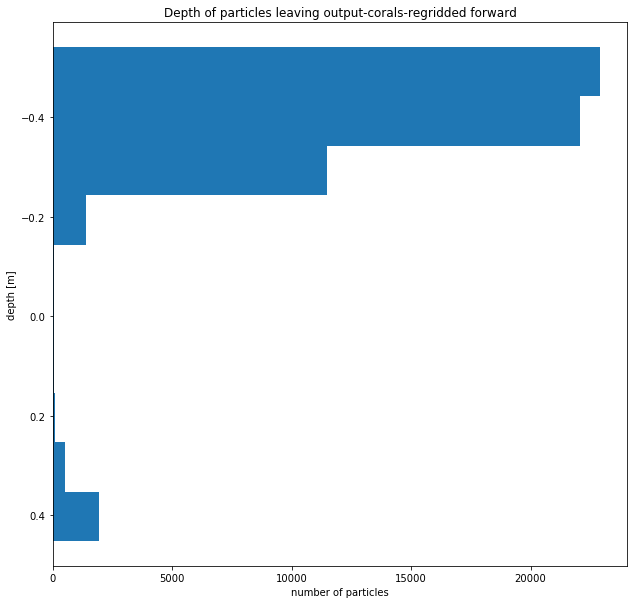

In [92]:
fig = plt.figure(figsize=(10.3,10))
ax = plt.axes()
plt.title('Depth of particles leaving '+filename+' '+fb)
plt.ylabel('depth [m]')
plt.xlabel('number of particles')
ax.barh(bineds[:-1],np.sum(zzs,axis=0),height=(bineds[-1]-bineds[-2]))
ax.invert_yaxis()
plt.savefig('Figures/depth-'+filename+'-'+fb)

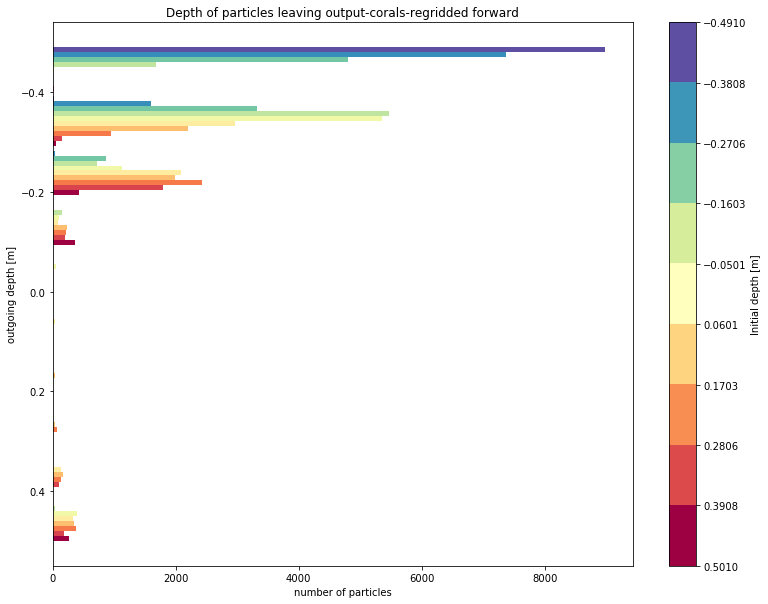

In [93]:
bounds = np.linspace(bineds[0], bineds[-1], nbins)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
partcolor = cm.ScalarMappable(norm=norm,cmap=cmap)

fig = plt.figure(figsize=(13,10))
ax = plt.axes()
plt.title('Depth of particles leaving '+filename+' '+fb)
plt.ylabel('outgoing depth [m]')
plt.xlabel('number of particles')
barwidth = (bineds[-1]-bineds[-2])/nbins
for i in range(len(zzs)):
    ax.barh(bineds[:-1]+i*barwidth,width=zzs[i],color=colors[i],align='edge',height=barwidth)
cbar = fig.colorbar(partcolor, ax=ax, label= 'Initial depth [m]')
cbar.ax.invert_yaxis()
ax.invert_yaxis()
plt.savefig('Figures/depth-'+filename+'-'+fb+'-absdepth')

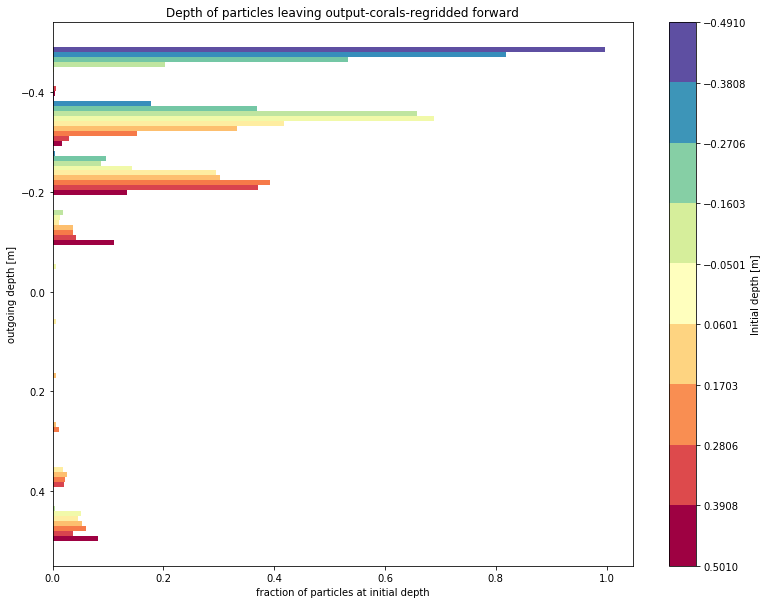

In [94]:
fig = plt.figure(figsize=(13,10))
ax = plt.axes()
plt.title('Depth of particles leaving '+filename+' '+fb)
plt.ylabel('outgoing depth [m]')
plt.xlabel('fraction of particles at initial depth')
barwidth = (bineds[-1]-bineds[-2])/nbins
for i in range(len(zzs)):
    ax.barh(bineds[:-1]+i*barwidth,width=zzs[i]/zs[i],color=colors[i],align='edge',height=barwidth)
cbar = fig.colorbar(partcolor, ax=ax, label= 'Initial depth [m]')
cbar.ax.invert_yaxis()
ax.invert_yaxis()
plt.savefig('Figures/depth-'+filename+'-'+fb+'-perdepth')

In [95]:
binedst = np.linspace(0,np.max(t)+1,nbins+1)
tm = t[t[:,-1].mask]
tt = np.zeros(len(tm))                                  # outgoing times for each particle
for i in range(len(tt)):
    tx = tm[i][~tm[i].mask]
    if len(tx)<len(t[0]):
        if fb == 'forward':
            tt[i] = tx[-1]                             # last time
        else:
            tt[i] = tx[0]-tx[-1]             # runtime - last time = time spent in domain

tts = np.zeros((nbins,nbins))
for i in range(len(tts)):
    mask = (bineds[i]<=zm[:,0]) & (zm[:,0]<=bineds[i+1])
    tts[i,:],binedst = np.histogram(tt[mask],binedst)

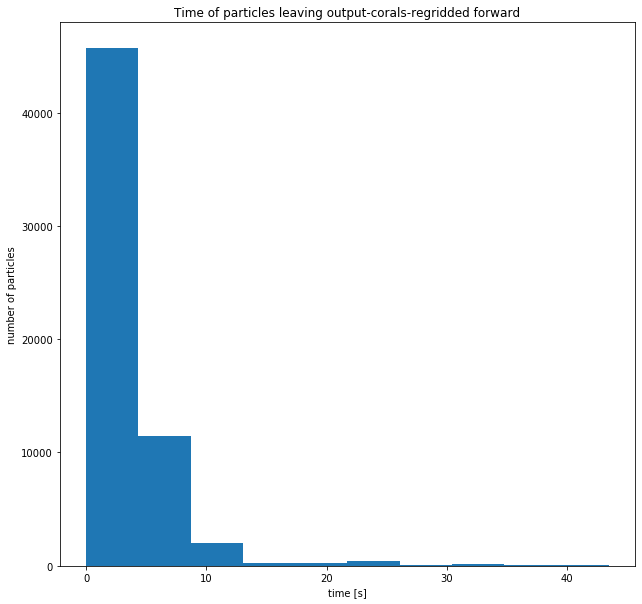

In [96]:
fig = plt.figure(figsize=(10.3,10))
ax = plt.axes()
plt.title('Time of particles leaving '+filename+' '+fb)
plt.ylabel('number of particles')
plt.xlabel('time [s]')
wt,wr,ww = ax.hist(tt)
plt.savefig('Figures/time-'+filename+'-'+fb)

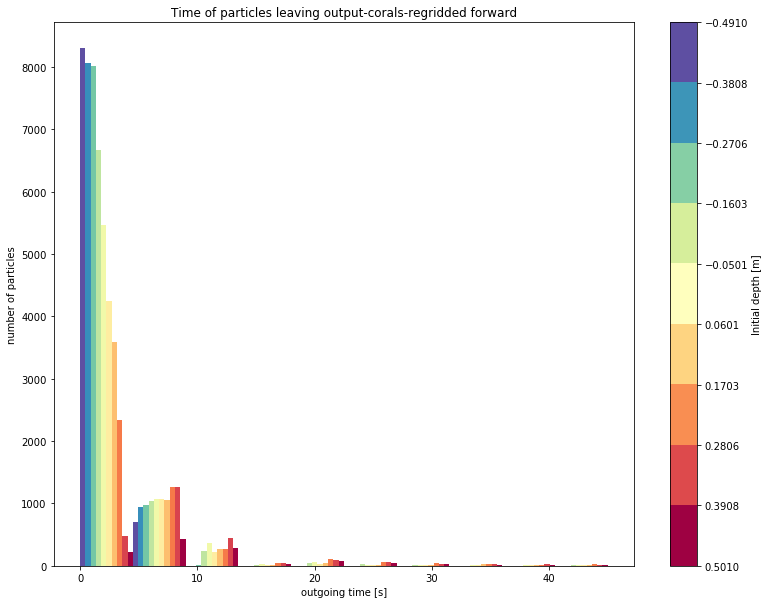

In [97]:
fig = plt.figure(figsize=(13,10))
ax = plt.axes()
plt.title('Time of particles leaving '+filename+' '+fb)
plt.ylabel('number of particles')
plt.xlabel('outgoing time [s]')
barwidth = (binedst[-1]-binedst[-2])/nbins
for i in range(len(tts)):
    ax.bar(binedst[:-1]+i*barwidth,tts[i],color=colors[i],align='edge',width=barwidth)
cbar = fig.colorbar(partcolor, ax=ax, label= 'Initial depth [m]')
cbar.ax.invert_yaxis()
plt.savefig('Figures/time-'+filename+'-'+fb+'-absdepth')

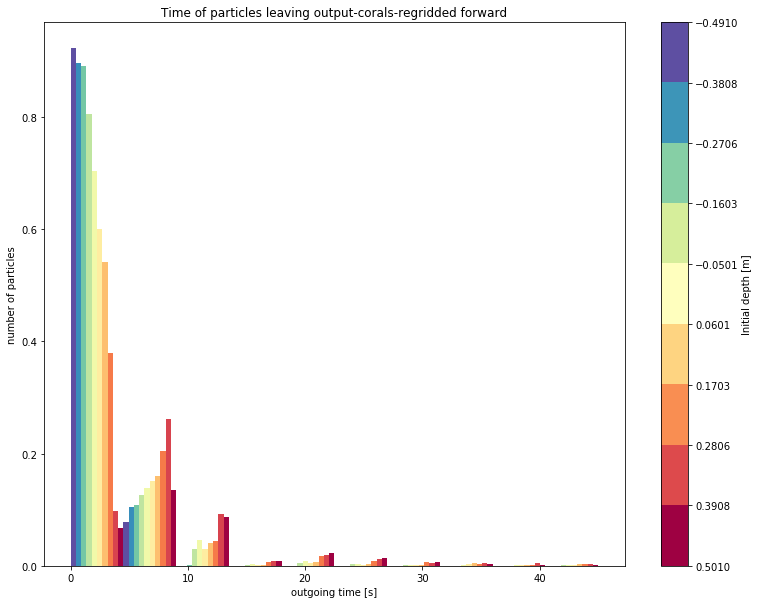

In [98]:
fig = plt.figure(figsize=(13,10))
ax = plt.axes()
plt.title('Time of particles leaving '+filename+' '+fb)
plt.ylabel('number of particles')
plt.xlabel('outgoing time [s]')
barwidth = (binedst[-1]-binedst[-2])/nbins
for i in range(len(tts)):
    ax.bar(binedst[:-1]+i*barwidth,tts[i]/zs[i],color=colors[i],align='edge',width=barwidth)
cbar = fig.colorbar(partcolor, ax=ax, label= 'Initial depth [m]')
cbar.ax.invert_yaxis()
plt.savefig('Figures/time-'+filename+'-'+fb+'-perdepth')

First we look at the beaching of the particles through time by counting how many final distances travelled are zero at each timestep.

In [99]:
ct = np.zeros(len(b[0]))
ct[-1] = np.count_nonzero(b[:,-1]==0)
beac = np.zeros((int(ct[-1]),2),dtype=np.int64)
beac[:,1] = np.nonzero(b[:,-1]==0)[0]
bn = b[beac[:,1]]
for i in range(len(bn)):
    cn = 0
    for j in np.arange(len(bn[i])-2,-1,-1):
        if bn[i,j] == 0:
            cn += 1
        else:
            break
    beac[i,0] = 44 - cn/10
for i in np.arange(len(b[0])-2,-1,-1): # each timestep
    ct[i] = np.count_nonzero(b[:,i]==0) #count how many values are zero            

In [100]:
zn = z[beac[:,1]]
beacs = np.zeros((nbins,nbins))
for i in range(len(beacs)):
    mask = (bineds[i]<=zn[:,0]) & (zn[:,0]<=bineds[i+1])
    beacs[i,:],taway = np.histogram(beac[:,0][mask],binedst)

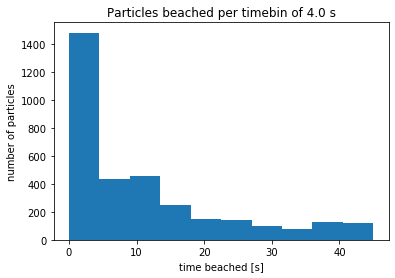

In [101]:
plt.hist(beac[:,0],binedst)
plt.title('Particles beached per timebin of '+str(round(binedst[-1]-binedst[-2]))+' s')
plt.ylabel('number of particles')
plt.xlabel('time beached [s]')
plt.ylim(bottom=0)
plt.savefig('Figures/beachedtime-'+filename+'-'+fb)

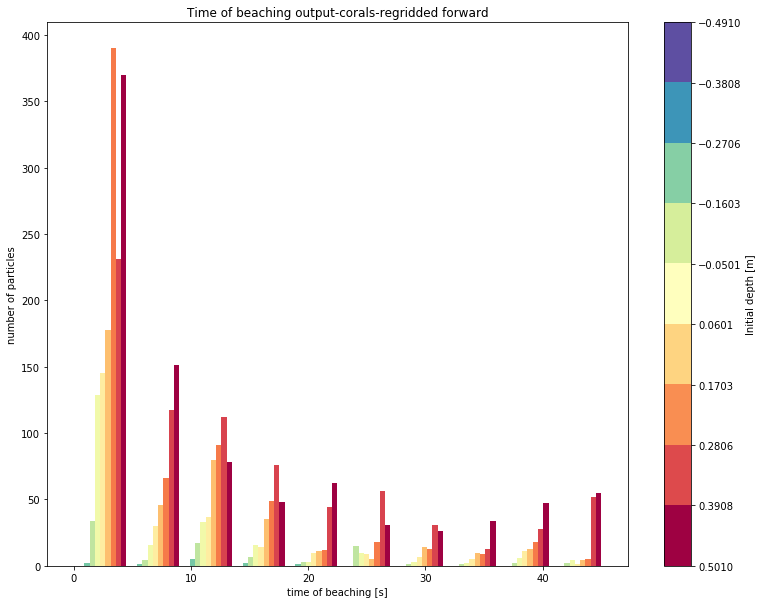

In [102]:
fig = plt.figure(figsize=(13,10))
ax = plt.axes()
plt.title('Time of beaching '+filename+' '+fb)
plt.ylabel('number of particles')
plt.xlabel('time of beaching [s]')
barwidth = (binedst[-1]-binedst[-2])/nbins
for i in range(len(beacs)):
    ax.bar(binedst[:-1]+i*barwidth,beacs[i],color=colors[i],align='edge',width=barwidth)
cbar = fig.colorbar(partcolor, ax=ax, label= 'Initial depth [m]')
cbar.ax.invert_yaxis()
plt.savefig('Figures/beachedtime-'+filename+'-'+fb+'-absdepth')

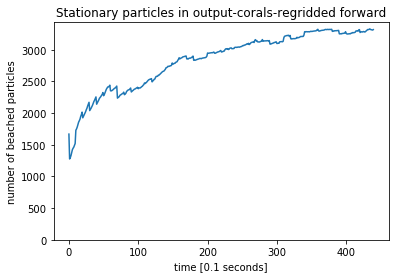

In [103]:
plt.plot(ct[1:])
plt.title('Stationary particles in '+filename+' '+fb)
plt.ylabel('number of beached particles')
plt.xlabel('time [0.1 seconds]')
plt.ylim(bottom=0)
plt.savefig('Figures/beached-'+filename+'-'+fb)

Finally, we are going to create plots to show the particles, coloured by their initial height.

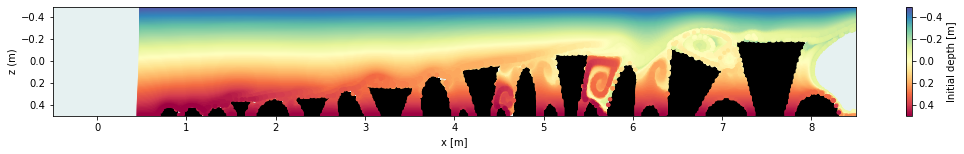

In [104]:
fig = plt.figure(figsize=(18,2))
ax = plt.axes()
ax.set_facecolor(coralcolor)
cf = ax.contourf(xf,depthf,uf[8,:,1,:],np.linspace(-10,-9,21),extend='both',cmap=cmocean.cm.dense_r)
cb = ax.scatter(x[:,10], z[:,10], c=z[:,0], s=10, marker="o",cmap=cmap)
cbar = fig.colorbar(cb,label='Initial depth [m]')
cbar.ax.invert_yaxis()
ax.set_xlabel("x [m]")
ax.set_ylabel("z (m)")
ax.set_xlim(-0.5,8.5)
ax.set_ylim(-0.49,0.5)
ax.invert_yaxis()
plt.show()

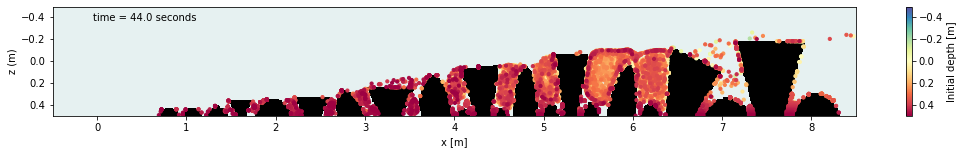

In [105]:
fig = plt.figure(figsize=(18,2))
ax = plt.axes()
ax.set_facecolor(coralcolor)
cf = ax.contourf(xf,depthf,uf[8,:,1,:],np.linspace(-10,-9,21),extend='both',cmap=cmocean.cm.dense_r)
sc = ax.scatter(x[:,0], z[:,0], c=z[:,0],s=10, marker="o",cmap=cmap)
topleft = 0.05
if fb == 'backward':
    topleft = 0.8
time_text = ax.text(topleft, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
cbar = fig.colorbar(sc,label='Initial depth [m]')
cbar.ax.invert_yaxis()

def animate(i,fig,sc):
    sc.set_offsets(np.c_[x[:,i], z[:,i]])
    ts = i*outputdt.microseconds/1000000
    if fb == 'b':
        ts = ts*-1
    time_text.set_text('time = %.1f seconds' % ts)
    return sc, time_text,

ax.set_xlabel("x [m]")
ax.set_ylabel("z (m)")
ax.set_xlim(-0.5,8.5)
ax.set_ylim(-0.49,0.5)
ax.invert_yaxis()
anim = animation.FuncAnimation(fig, animate, fargs = (fig, sc),
                               frames = len(x[0]), blit=True)
anim.save('Figures/'+filename+'-'+str(runtime.seconds)+'-'+fb+'.mp4')
plt.show()